### Model assessment
Here we compared the weights learned by several model iterations, to highlight
- Performance user parameter combinations
- Interpretation based on TF regulators
- Coherence or learned graph-weights when assisting RNA-weights, or only using ATAC-weights

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
cd ~/workspace/theislab/mubind/docs/notebooks/scatac

/mnt/c/Users/IgnacioIbarra/Dropbox/workspace/theislab/mubind/docs/notebooks/scatac


/home/ilibarra/.conda/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/ilibarra/.conda/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
import torch
import mubind as mb
import scanpy as sc

In [5]:
# load models
model_by_logdynamic = {}
for use_logdynamic in [False, True]:
    p = 'pancreas_multiome_use_logdynamic_%i.pth' % use_logdynamic
    print(p)
    model_by_logdynamic[use_logdynamic] = torch.load(p)

pancreas_multiome_use_logdynamic_0.pth
pancreas_multiome_use_logdynamic_1.pth


In [6]:
ad = sc.read_h5ad('atac_train.h5ad')
rna_sample = sc.read_h5ad('rna_sample_train.h5ad')

In [7]:
import pickle
train = pickle.load(open('train_dataloader.pkl', 'rb'))

In [8]:
%load_ext line_profiler

In [9]:
# load the pancreas multiome dataset
rna, atac = mb.datasets.pancreas_multiome() # data_directory='../../../annotations/scatac')


True data/scatac/pancreas_multiome/pancreas_multiome_2022_processed_rna_velocities_2024.h5ad
True data/scatac/pancreas_multiome/pancreas_multiome_2022_processed_atac.h5ad


In [10]:
# %lprun -f model.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [11]:
# %lprun -f model.binding_modes.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [12]:
import matplotlib.pyplot as plt

False
True
3
order None
0 out of 288...
break


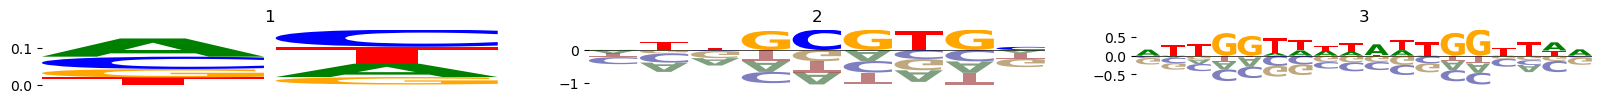

True
True
3
order None
0 out of 288...
break


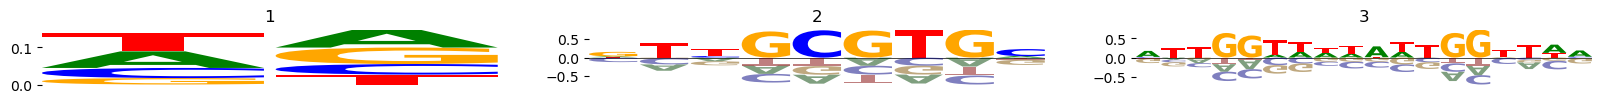

In [13]:

for optimize_log_dynamic in model_by_logdynamic:
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 20, 5
    rcParams['figure.dpi'] = 100
    mb.pl.logo(model, n_cols=3, show=True, n_rows=6, stop_at=4) #  log=True)
    plt.show()


True


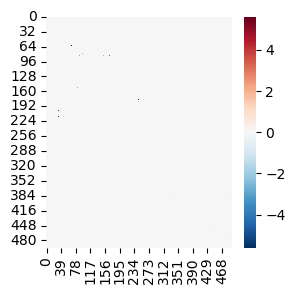

In [14]:
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)

    tsum = torch.sum
    texp = torch.exp
    tspa = torch.sparse_coo_tensor
    tsmm = torch.sparse.mm
    t = torch.transpose

    # connectivities
    C = model.graph_module.conn_sparse
    a_ind = C.indices()

    log_dynamic = model.graph_module.log_dynamic
    D = model.graph_module.log_dynamic
    D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
    D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
    D = D_tril + t(D_triu, 0, 1)
    # log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
    # triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
    D

    import seaborn as sns
    mb.pl.set_rcParams({'figure.figsize': [3, 3]})
    sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')
    plt.show()

In [15]:
model = model_by_logdynamic[1]

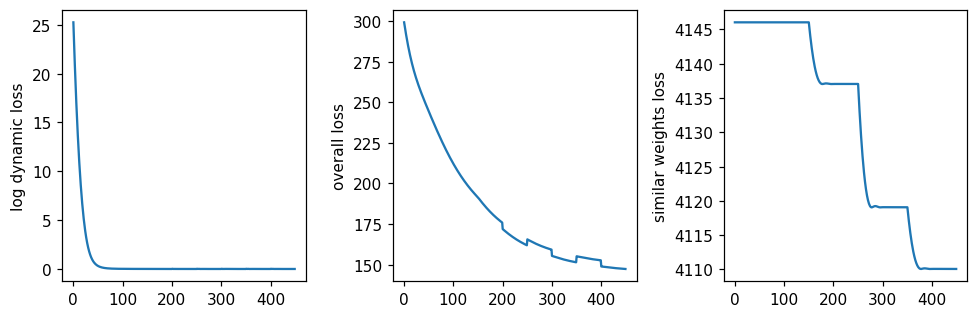

In [16]:
mb.pl.set_rcParams({'figure.figsize': [12, 3], 'figure.dpi': 110})
plt.subplot(1, 4, 1)
plt.plot(model.loss_history_log_dynamic)
plt.ylabel('log dynamic loss')
plt.subplot(1, 4, 2)
plt.plot(model.loss_history)
plt.ylabel('overall loss')
plt.subplot(1, 4, 3)
plt.plot(model.loss_history_sym_weights)
plt.ylabel('similar weights loss')
plt.tight_layout()
plt.show()

In [17]:
import pandas as pd
import numpy as np

False
True


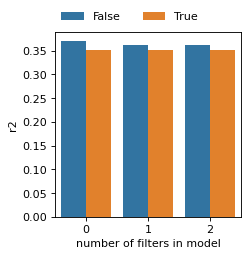

In [18]:
rcParams['figure.figsize'] = 3, 5
r2_all = []
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # contributions per newly added kernel
    import seaborn as sns
    if len(model.best_r2_by_new_filter) != 0:
        r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
        r2['opt_log_dynamic'] = optimize_log_dynamic
        r2_all.append(r2)

if len(r2_all) > 0:
    r2_all = pd.concat(r2_all)
    rcParams['figure.figsize'] = 3, 3
    rcParams['figure.dpi'] = 80
    ax = sns.barplot(data=r2_all, x='index', y='r2', hue='opt_log_dynamic', )
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.4, 1), ncol=3, title=None, frameon=False)

    plt.xlabel('number of filters in model')
    plt.show()

In [19]:

model = model_by_logdynamic[True]

torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)
# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs['dynamic_score'] = dynamic_score

ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2


In [20]:
ad.obs['dynamic_score'].describe()

count    496.000000
mean       0.532708
std        0.069737
min        0.000000
25%        0.532691
50%        0.532708
75%        0.532715
max        1.000000
Name: dynamic_score, dtype: float64

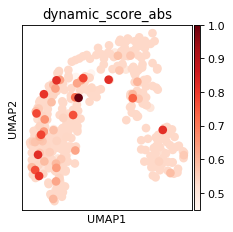

In [21]:
ad.obs['dynamic_score_abs'] = ad.obs['dynamic_score'].abs()
sc.pl.umap(ad, color='dynamic_score_abs', color_map='Reds', vmin=.45)

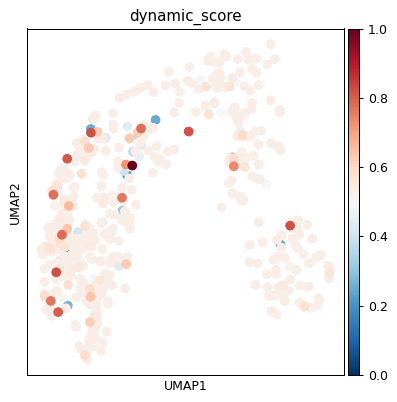

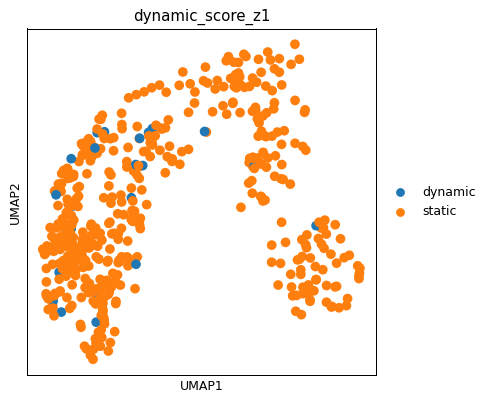

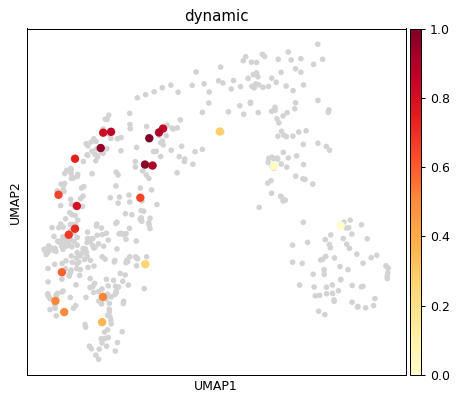

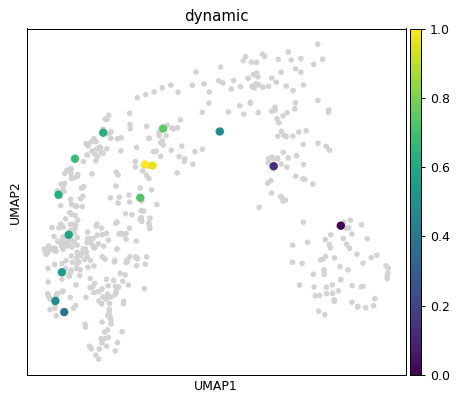

In [22]:


# contributions per newly added kernel
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)

sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic', color_map='viridis') # basis='umap', groupby='dynamic_score_cluster')

<Axes: >

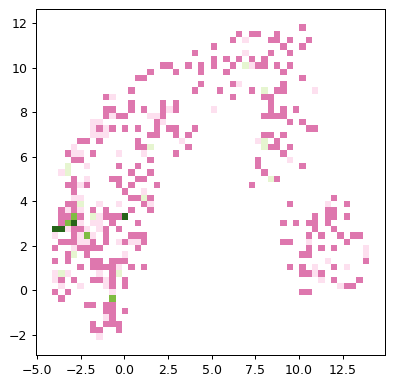

In [23]:
import seaborn as sns
umap = ad.obsm['X_umap']
sns.histplot(x=umap[:, 0], y=umap[:, 1], bins=50, cmap='PiYG')

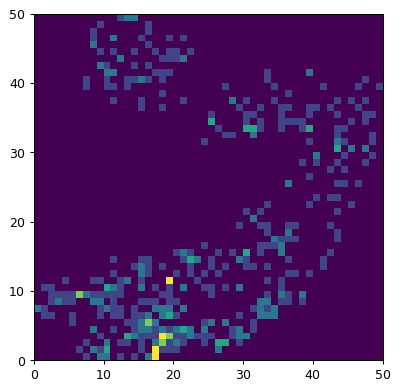

In [24]:
plt.pcolormesh(
    np.histogram2d(umap[:, 0], umap[:, 1], bins=50)[0]
)

In [25]:
x, y = np.meshgrid(umap[:, 0], umap[:, 1])

In [26]:
x = umap[:,1] # array_txt[:,0]
y = umap[:,1] # array_txt[:,1]
z = ad.obs['dynamic_score'].values # array_txt[:,2]


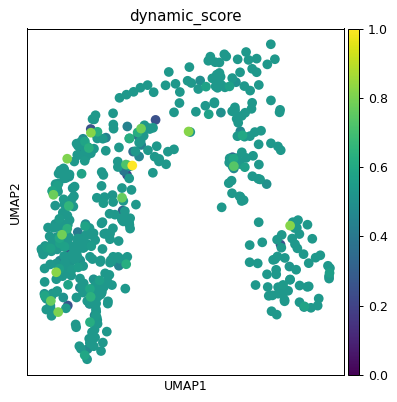

In [27]:
sc.pl.umap(ad, color='dynamic_score')

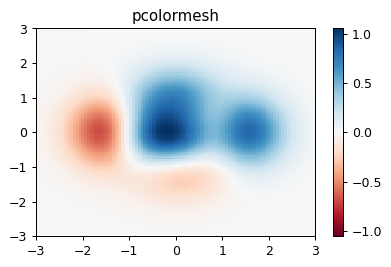

In [28]:
import matplotlib.pyplot as plt
import numpy as np
rcParams['figure.figsize'] = 5, 3

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [29]:
import itertools
import numpy as np

def grid(x, y, z, size_x=1, size_y=1):

    def pairwise(iterable):
        "s -> (s0,s1), (s1,s2), (s2, s3), ..."
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)

    minx, maxx = int(min(x)), int(max(x)) + 1
    miny, maxy = int(min(y)), int(max(y)) + 1

    result = []
    x_edges = pairwise(np.arange(minx, maxx + 1, size_x))
    for xleft, xright in x_edges:
        xmask = np.logical_and(x >= xleft, x < xright)
        y_edges = pairwise(np.arange(miny, maxy + 1, size_y))
        for yleft, yright in y_edges:
            ymask = np.logical_and(y >= yleft, y < yright)
            cell = z[np.logical_and(xmask, ymask)]
            result.append(cell.sum())

    result = np.array(result).reshape((maxx - minx, maxy - miny))
    return np.flip(result.T, 0)


In [30]:
grid_dyn_score = grid(umap[:,0], umap[:,1], ad.obs['dynamic_score'], size_x=1, size_y=1)
grid_counts = grid(umap[:,0], umap[:,1], ad.obs['celltype'].cat.codes.values, size_x=1, size_y=1)

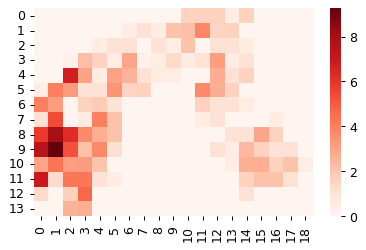

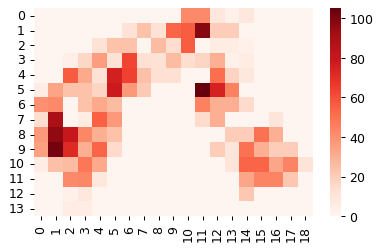

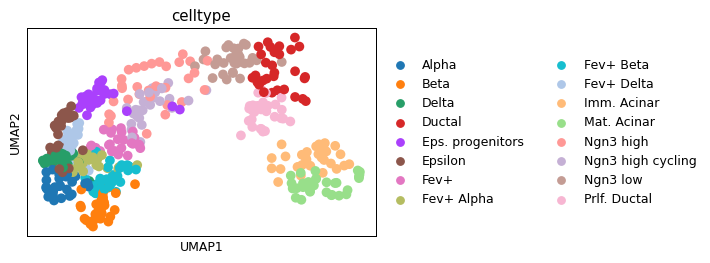

In [31]:

sns.heatmap(grid_dyn_score, cmap='Reds')
plt.show()
sns.heatmap(grid_counts, cmap='Reds')
plt.show()

sc.pl.umap(ad, color='celltype')

In [32]:
# for optimize_log_dynamic in model_by_logdynamic:
#     mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
#     print(optimize_log_dynamic)
#     model = model_by_logdynamic[optimize_log_dynamic]
#     mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)
#     plt.show()

#     mb.pl.set_rcParams({'figure.figsize': [10, 7], 'figure.dpi': 90})
#     mb.pl.logo(model,
#                title=False,
#                xticks=False,
#                rowspan_dinuc=0,
#                rowspan_mono=1,
#                n_rows=12,
#                n_cols=3,
#                stop_at=20) # n_cols=len(reduced_groups))
#     plt.show()


In [33]:
model = model_by_logdynamic[True]

In [34]:
G = model.graph_module.conn_sparse.detach().cpu().to_dense() # (C, C)

In [35]:
# number of non_zero weights
len(G[G != 0])

870

In [36]:
# output = model(**inputs, use_conn=False, return_binding_scores=True)

In [37]:
print('here...')

here...


In [38]:
ad

AnnData object with n_obs × n_vars = 496 × 250
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic_score_z2', 'dynamic_score_abs', 'umap_density_dynamic_score_z1', 'umap_density_dynamic_score_z2'
    var: 'modality', 'acc_score', 'acc_score_rank', 'chr', 'start', 'end', 'summit', 'summit.start', 'summit.end', 'k.summit'
    uns: 'celltype_colors', 'neighbors', 'dynamic_score_z1_colors', 'umap_density_dynamic_score_z1_params', 'umap_density_dynamic_score_z2_params'
    obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_umap_wsnn', 'lsi_full', 'lsi_red', 'umap', 'umap_ATAC', 'umap_GEX'
    obsp: 'connectivities

In [39]:
model = model.cuda()

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device

In [41]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic].cuda()

    umap = ad.obsm['X_umap'].copy()
    umap = np.sort(umap, 0)

    x = umap[:,0]
    y = umap[:,1]
    X, Y = np.meshgrid(x, y)

    n_points = x.shape[0]
    # x-component to the right
    u = np.ones((n_points, n_points))
    # y-component zero
    v = np.zeros((n_points, n_points))

    pred = []
    for i, batch in enumerate(train):
        # Get a batch and potentially send it to GPU memory.
        mononuc = batch["mononuc"].to(device)
        # print(i, mononuc.shape)
        b = batch["batch"].to(device) if "batch" in batch else None
        rounds = batch["rounds"].to(device) if "rounds" in batch else None
        countsum = batch["countsum"].to(device) if "countsum" in batch else None
        seq = batch["seq"] if "seq" in batch else None
        residues = batch["residues"].to(device) if "residues" in batch else None
        if residues is not None and train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum,
                      "residues": residues}
        elif residues is not None:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
        elif train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
        else:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

        inputs['scale_countsum'] = model.datatype == 'selex'
        output = model(**inputs, use_conn=False, return_binding_scores=True)

        output = output.cpu().detach().numpy()
        print('here...')
        print(output.shape)

        print(output.sum())
        pred.append(output)

    # pred = np.concatenate(pred).T

    binding_scores = np.concatenate(pred).T


    # ad.layers['velocity'] = pred
    
    # conn = model.graph_module.conn_sparse.detach().cpu()
    # conn = model.graph_module.conn_sparse.detach().cpu().to_dense()
    # v = conn.sum(axis=1)
    # ad.layers['velocity'] = torch.stack([v,] * ad.shape[1], axis=1).numpy()
    
    # ad.layers['counts'] = ad.X

    # mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 90})
    # plt.hist(model.graph_module.conn_sparse.values().detach().cpu().numpy())
    # plt.show()

    # import scvelo as scv

    # sc.pp.neighbors(ad)

    # # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # # ad.layers['velocity'] = ad.obs['dynamic_score']
    
    # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)


X = ad.X.A
G @ binding_scores
np.random.shuffle(binding_scores)

False
True
here...
(250, 496)
214448750000.0


In [42]:
import scvelo as scv

In [43]:
ad
ad.layers['velocity'] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

In [44]:
np.random.shuffle(binding_scores)
binding_scores

array([[1685022.5, 1605481.5, 1549909. , ..., 1581368. , 1793194.5,
        1740319.4],
       [1721065. , 1638159.5, 1581044. , ..., 1614565.2, 1831365.8,
        1775428.5],
       [1721065. , 1638159.5, 1581044. , ..., 1614565.2, 1831365.8,
        1775428.5],
       ...,
       [1721065. , 1638159.5, 1581044. , ..., 1614565.2, 1831365.8,
        1775428.5],
       [1717321.5, 1634840.2, 1577904.6, ..., 1611514.8, 1827327.2,
        1771159. ],
       [1667096.8, 1589986. , 1534665.8, ..., 1566279.1, 1773899. ,
        1720141.2]], dtype=float32)

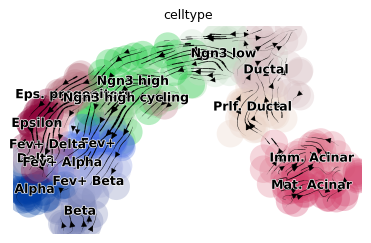

In [45]:
try:
    scv.pl.velocity_embedding_stream(rna_sample, color='celltype')
except Exception:
    print("sample too small.")

In [46]:
# np.random.shuffle(binding_scores)
# ad.layers['velocity'] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

<Axes: >

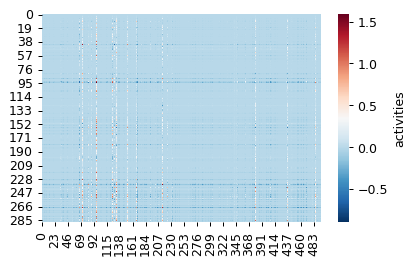

In [47]:
import seaborn as sns
act = model.get_log_activities().detach().cpu().squeeze(0)
sns.heatmap(act, cmap='RdBu_r', cbar_kws={'label': 'activities'})

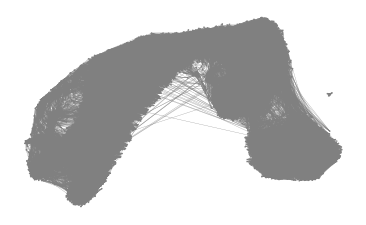

In [48]:
scv.pl.velocity_graph(rna)

In [49]:

# ax = scv.pl.velocity_embedding_stream(ad,
#                                       color='celltype',
#                                       # density=2,
#                                       arrow_color='black',
#                                       n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [50]:
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', density=2, arrow_color='black', n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [51]:
# scv.pl.velocity_embedding_stream(ad, color='celltype', n_neighbors=15) #  X_grid='X_umap', V=V)

## Study the asssociations betweeen obtained weights and cluster-specific transcription factors

Load information from archetypes DB (Vierstra et al 2020)

In [52]:
rna_sample, ad.shape

(AnnData object with n_obs × n_vars = 496 × 14663
     obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'batch', 'velocity_self_transition'
     var: 'modality', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
     uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
     obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_umap_wsnn', 'lsi_full', 'lsi_red', 'umap', 'umap_ATAC', 'umap_GEX', 'velocity_umap'
     layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 

In [53]:
rna_sel = rna_sample # rna[rna.obs_names.isin(ad.obs_names),:].copy()
rna_sel.shape

(496, 14663)

In [54]:
pwd

'/mnt/c/Users/IgnacioIbarra/Dropbox/workspace/theislab/mubind/docs/notebooks/scatac'

In [55]:
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'

anno = mb.datasets.archetypes_anno()

In [56]:
rna_sel.shape
anno.sort_values('Cluster_ID')

,Cluster_ID,Name,DBD,Seed_motif,Total_width,Consensus_left,Consensus_right,Cluster_size
61,1,HD/1,homeodomain,LHX6_homeodomain_3,12,0,12,2
72,2,HD/2,homeodomain,ALX3_MA0634.1,26,8,16,186
79,3,HD/3,homeodomain,VENTX_homeodomain_2,21,3,20,1
80,4,HD/4,homeodomain,BARX1_MOUSE.H11MO.0.C,17,5,13,17
81,5,HD/5,homeodomain,BARX1_homeodomain_1,21,2,18,6
...,...,...,...,...,...,...,...,...
163,282,PAX/2,PAX,PAX5_HUMAN.H11MO.0.A,24,4,21,3
161,283,PAX-halfsite,PAX,Pax2_MA0067.1,8,1,7,1
0,284,AHR,bHLH,AHR_HUMAN.H11MO.0.B,9,2,8,3
105,285,KLF/SP/3,C2H2,KLF8_HUMAN.H11MO.0.C,9,0,9,2


False


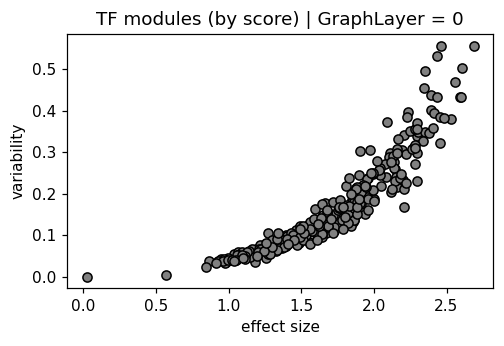

True


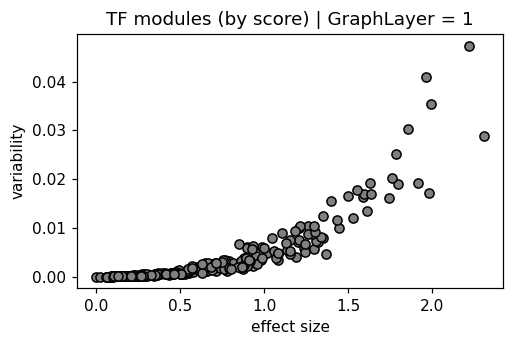

In [57]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    # log_act.columns = ['intercept', 'dinuc_bias'] + list(anno['Seed_motif'].values)
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 110})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var, color='gray', edgecolors='black')
    plt.xlabel('effect size')
    plt.ylabel('variability')
    plt.title('TF modules (by score) | GraphLayer = %i' % optimize_log_dynamic )
    plt.show()

In [58]:
# unique names for annotation
names = anno['Name'] # .sort_values('Name')
added = dict()
new_name = []
for name in names:
    if not name in added:
        new_name.append(name)
        added[name] = 0
    else:
        new_name.append(name + '_%i' % added[name])
        added[name] += 1
anno['Name_unique'] = new_name


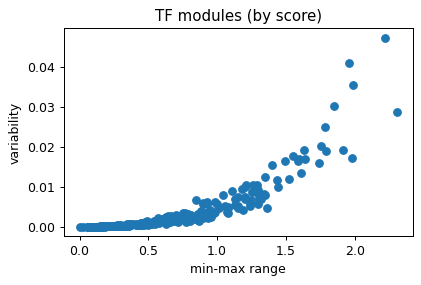

In [59]:
from scipy.stats import spearmanr
res = []
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue

    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    log_act.columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 90})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var)
    plt.xlabel('min-max range')
    plt.ylabel('variability')
    plt.title('TF modules (by score)')
    plt.show()

    for c in log_act:
        a = log_act[c]
        b = ad.obs['dynamic_score'].values
        # print(a.shape, b.shape)
        res.append([optimize_log_dynamic, c] + list(spearmanr(a, b)))

res = pd.DataFrame(res, columns=['opt_log_dynamic', 'archetype_id', 'spearman', 'p_val'])



In [60]:

# add archetypes name
meta = pd.DataFrame(pd.concat([delta, var], axis=1))
meta.columns = ['max_effect', 'variability']
meta['name'] = ['intercept', 'dinuc_bias'] + list(range(1, 287))
clu = mb.datasets.archetypes_clu()
meta['archetypes_name'] = meta['name'].map(anno.set_index('Cluster_ID')['Name_unique'])
meta['archetypes_name'] = np.where(pd.isnull(meta['archetypes_name']), meta['name'], meta['archetypes_name'])

meta['archetypes_seed'] = meta['name'].map(anno.set_index('Cluster_ID')['Seed_motif'])
meta = meta.sort_values('max_effect', ascending=0)
meta

res = res.merge(meta, left_on='archetype_id', right_on='name')
res = res.sort_values('p_val', ascending=True)

In [61]:
name_by_filter_id = meta['archetypes_name'].to_dict()
# name_by_filter_id

## Observe general scores per case

<Axes: xlabel='max_effect', ylabel='archetypes_name'>

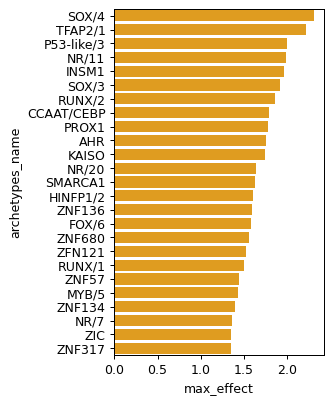

In [62]:
rcParams['figure.figsize'] =3, 5
sns.barplot(data=res.sort_values('max_effect', ascending=False).head(25), x='max_effect', y='archetypes_name', color='orange')

In [63]:
res

,opt_log_dynamic,archetype_id,spearman,p_val,max_effect,variability,name,archetypes_name,archetypes_seed
53,True,52,-0.203407,0.000005,1.792982,0.018920,52,CCAAT/CEBP,CEBPA_HUMAN.H11MO.0.A
252,True,251,-0.175836,0.000083,1.551822,0.017810,251,ZNF680,ZN680_HUMAN.H11MO.0.C
131,True,130,-0.164542,0.000233,0.346629,0.000463,130,OSR2,OSR2_HUMAN.H11MO.0.C
104,True,103,-0.149740,0.000822,0.449558,0.000827,103,IRF/3,IRF5_IRF_1
105,True,104,-0.142210,0.001497,1.203825,0.007590,104,IRF/1,IRF2_MA0051.1
...,...,...,...,...,...,...,...,...,...
250,True,249,0.001367,0.975780,1.261980,0.010481,249,HSF,HSF1_HSF_1
97,True,96,-0.001293,0.977083,0.368373,0.000492,96,ETS/2,EHF_HUMAN.H11MO.0.B
209,True,208,0.000961,0.982970,0.177106,0.000124,208,ZNF146,OZF_HUMAN.H11MO.0.C
47,True,46,-0.000565,0.989993,0.628022,0.001193,46,NR/17,ESR1_HUMAN.H11MO.0.A


True
1
order None
0 out of 288...
10 out of 288...
break


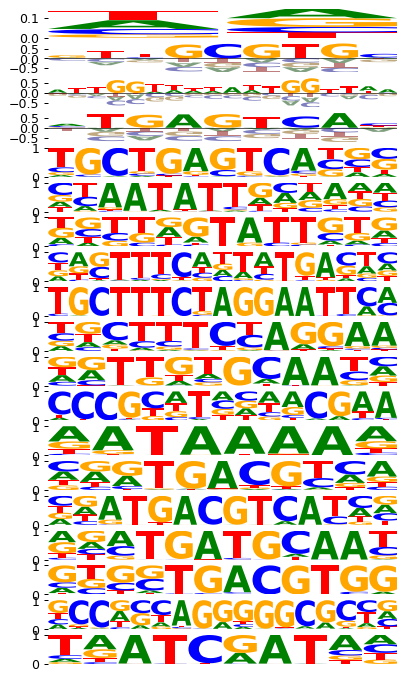

In [64]:
# visualize the logos as obtained by the model in each step
mb.pl.set_rcParams({'figure.figsize': [5, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40, n_cols=1, stop_at=20)
           # n_rows=len(res.head(20).index),

True
1
order Index([ 53, 252, 131, 104, 105,  27,  37, 106,  93,  49, 127,  41, 133, 257,
       166, 126, 276, 224, 213, 181],
      dtype='int64')
0 out of 288...
10 out of 288...


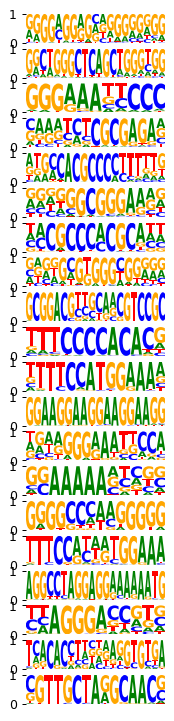

<Figure size 180x1800 with 0 Axes>

In [65]:
mb.pl.set_rcParams({'figure.figsize': [2, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40,
           # n_rows=len(res.head(20).index),
           n_cols=1, order=res.head(20).index) # n_cols=len(reduced_groups))
plt.tight_layout()
plt.show()

In [66]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)


total GB used: 8.747884


In [67]:
# for k in ad.obsm['log_activities'].iloc[:,2:]:
#     ad.obs[str(k)] = ad.obsm['log_activities'][k]
# sc.pl.umap(ad, color=map(str, ad.obsm['log_activities'].iloc[:,2:]), cmap='Reds')


In [68]:
rna_sel.obsm['X_umap'] = ad.obsm['X_umap']

In [69]:
def find_varname(ad, k):
    return ad.var_names[ad.var_names.str.upper().str.contains(k.upper())]

In [70]:
from scipy.stats import spearmanr

Calculate global correlations between the activities obtained per motif and gene-specific expression

In [71]:

all_targets = set()
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

    # collect all targets
    for k in ad.obsm['log_activities'].iloc[:,2:]:
        log_act = ad.obsm['log_activities'][k].values
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            for t in target:
                all_targets.add(t)
        if len(targets) > 0 and False:
            sc.pl.umap(rna_sel, color=targets, cmap='Reds')


False
True


In [72]:


print('association between motif activities and related TF targets ')
res = []
print(len(all_targets))

rna_sel_df = rna_sel.to_df()

for optimize_log_dynamic in model_by_logdynamic:
    print('use GraphLayer = %i' % optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

    log_act = ad.obsm['log_activities'][k].values
    for ki, k in enumerate(ad.obsm['log_activities'].iloc[:,2:]):
        # print(ki)
        if ki % 30 == 0:
            print(ki)
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        next_targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            # print(name, target)
            for t in target:
                next_targets.add(t)

        # for t in all_targets:
        for t in set(all_targets).intersection(next_targets):
            gex = rna_sel_df[[t]].to_numpy() # rna_sel_df[t].A
            assert gex.shape[1] == 1
            gex = gex.flatten()
            # print(log_act.shape, gex.shape)
            # print(t, pearsonr(log_act, gex))
            res.append([ki, optimize_log_dynamic, k, t, t in next_targets] +
                       list(spearmanr(log_act, gex)))
            
res = pd.DataFrame(res, columns=['filter_id', 'opt_log_dynamic', 'archetype_id', 'gene_name', 'matched', 'spearman', 'p_val'])

# p-values
res['module_name'] = res['archetype_id'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
res['p_val'] = np.where(pd.isnull(res['p_val']), 1.0, res['p_val'])

# p-val adjust
from statsmodels.stats.multitest import fdrcorrection
res['p_adj'] = fdrcorrection(res['p_val'])[1]
res[res['p_adj'] < 0.1]

association between motif activities and related TF targets 
3828
use GraphLayer = 0
0
30
60
90
120
150
180
210
240
270
use GraphLayer = 1
0
30
60
90
120
150
180
210
240
270


,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
27,1,False,2,Abraxas2,True,0.124766,5.393684e-03,HD/2,0.098817
538,69,False,70,Fstl1,True,0.136242,2.359576e-03,TBX/1,0.055334
649,69,False,70,Tcerg1,True,0.136371,2.336964e-03,TBX/1,0.055320
666,69,False,70,Gpatch1,True,0.142874,1.421160e-03,TBX/1,0.040446
821,69,False,70,Thnsl2,True,0.142094,1.510167e-03,TBX/1,0.042565
...,...,...,...,...,...,...,...,...,...
8753,256,True,257,Trp53inp2,True,-0.131015,3.465822e-03,P53-like/1,0.072618
8757,256,True,257,Trp53i13,True,-0.162064,2.898479e-04,P53-like/1,0.012820
8761,257,True,258,Grhl2,True,0.209765,2.447935e-06,GRHL,0.000336
8765,260,True,261,Glis3,True,0.169514,1.487053e-04,GLIS,0.007647


In [73]:
genes_by_module_name = res.groupby(['module_name'])['gene_name'].apply(lambda grp: list(grp.value_counts().index)).to_dict()
genes_by_module_name

{'AHR': ['Ahr'],
 'AIRE': ['Aire'],
 'AP1/1': ['Junos',
  'Jdp2',
  'Fosb',
  'Fosl2',
  'Junb',
  'Fosl1',
  'Fos',
  'Nfe2',
  'Nfe2l1',
  'Atf3',
  'Jun',
  'Jund',
  'Batf2',
  'Nfe2l3',
  'Nfe2l2'],
 'AP1/2': ['Maff',
  'Bach1',
  'Bach2',
  'Nsmaf',
  'Mafk',
  'Maf',
  'Nfe2',
  'Mafg',
  'Mafa',
  'Nfe2l1',
  'Nfe2l2',
  'Mafb',
  'Nfe2l3',
  'Maf1'],
 'ARI5A': ['Arid5a'],
 'BATF': ['Batf2'],
 'BCL6/1': ['Bcl6b'],
 'BCL6/2': ['Bcl6b', 'Bcl6'],
 'CCAAT/CEBP': ['Cebpd',
  'Dbp',
  'Cebpg',
  'Ccndbp1',
  'Tefm',
  'Tardbp',
  'Dbpht2',
  'Tef',
  'Nfil3',
  'Cebpa',
  'Cebpb'],
 'CENBP': ['Cenpb'],
 'CPEB1': ['Cpeb1'],
 'CREB/ATF/1': ['Junos',
  'Atf1',
  'Fosb',
  'Fosl2',
  'Junb',
  'Fosl1',
  'Fos',
  'Jun',
  'Creb1',
  'Atf2',
  'Atf3',
  'Crem',
  'Jund',
  'Batf2'],
 'CREB/ATF/2': ['Junos',
  'Creb5',
  'Jdp2',
  'Jund',
  'Xbp1',
  'Junb',
  'Paxbp1',
  'Creb3l1',
  'Creb3l2',
  'Mafb',
  'Atf7',
  'Creb3',
  'Jun',
  'Atf7ip2',
  'Atf7ip',
  'Stxbp1',
  'Creb3l4'],
 'CR

In [74]:
res.sort_values('p_adj')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
4403,1,True,2,Isl1,True,-0.398203,2.692688e-20,HD/2,2.367950e-16
6003,69,True,70,St18,True,-0.350859,8.167989e-16,TBX/1,3.591465e-12
5067,69,True,70,Malat1,True,-0.312596,1.051707e-12,TBX/1,3.082905e-09
7657,69,True,70,Stxbp5l,True,-0.304192,4.443414e-12,TBX/1,9.768846e-09
7187,69,True,70,Ptprn2,True,-0.302758,5.656232e-12,TBX/1,9.948181e-09
...,...,...,...,...,...,...,...,...,...
1153,69,False,70,Tmem45a,True,NaN,1.000000e+00,TBX/1,1.000000e+00
3042,69,False,70,D16Ertd472e,True,0.000067,9.988122e-01,TBX/1,1.000000e+00
4624,53,True,54,Jdp2,True,NaN,1.000000e+00,AP1/1,1.000000e+00
5881,69,True,70,Sftpc,True,-0.000058,9.989681e-01,TBX/1,1.000000e+00


In [75]:
res['k'] = res['gene_name'] + '_' + res['archetype_id'].astype(str)
df2 = res.pivot(index='k', columns='opt_log_dynamic', values='spearman')
# df2 = res # .pivot(index='k', columns='opt_log_dynamic', values='spearman')

In [76]:
df2

opt_log_dynamic,False,True
k,,
A3galt2_70,-0.066026,0.031264
Aar2_248,0.093434,0.018050
Aard_248,0.008296,0.014095
Aars2_248,-0.015747,0.071690
Aars_248,0.132731,-0.022168
...,...,...
mt-Nd3_70,0.062752,0.037485
mt-Nd4_70,0.056020,-0.011148
mt-Nd4l_70,0.061812,0.024266


In [77]:
mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 120})
# df2 = df2.sort_values('matched', ascending=True)
# plt.scatter(df2[True], df2[True],
#             color=np.where(df2['matched'], 'blue', 'gray'),
#             s=np.where(df2['matched'], 30, 5))
# plt.xlabel('TF activity (graph = off)')
# plt.ylabel('TF activity (graph = on)')
# plt.axhline(0, color='gray', ls='--', zorder=0)
# plt.axvline(0, color='gray', ls='--', zorder=0)


In [78]:
# df2[df2['matched'] == True].sort_values(True, ascending=False)

In [79]:
# res['arch_name'] = name_by_filter_id

In [80]:
res

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
0,1,False,2,Arx,True,-0.033242,4.601043e-01,HD/2,0.846831,Arx_2
1,1,False,2,Lmx1b,True,0.003826,9.322737e-01,HD/2,0.986662,Lmx1b_2
2,1,False,2,Kremen1,True,0.030650,4.958490e-01,HD/2,0.857521,Kremen1_2
3,1,False,2,Pou6f1,True,-0.066245,1.406851e-01,HD/2,0.573589,Pou6f1_2
4,1,False,2,Arxes2,True,-0.006100,8.922027e-01,HD/2,0.979378,Arxes2_2
...,...,...,...,...,...,...,...,...,...,...
8789,280,True,281,Pax6os1,True,-0.091745,4.110968e-02,PAX/1,0.314214,Pax6os1_281
8790,280,True,281,Pax6,True,-0.232802,1.572322e-07,PAX/1,0.000038,Pax6_281
8791,282,True,283,Pax2,True,0.029077,5.182274e-01,PAX-halfsite,0.863911,Pax2_283
8792,283,True,284,Ahr,True,0.032063,4.761827e-01,AHR,0.849574,Ahr_284


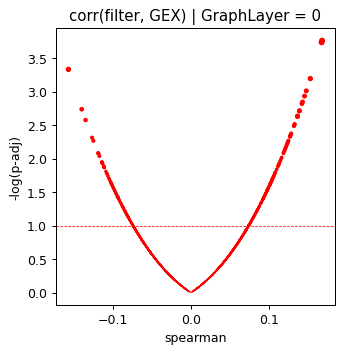

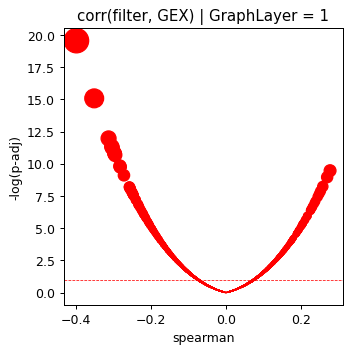

In [81]:
rcParams['figure.figsize'] = 4, 4
rcParams['figure.dpi'] = 90

for optimize_log_dynamic, grp in res.groupby('opt_log_dynamic'):
    grp['minus_log10_pval'] = -np.log10(grp['p_val'])
    grp = grp.sort_values('matched')
    plt.scatter(grp['spearman'], grp['minus_log10_pval'],
                s=np.power(grp['minus_log10_pval'], 2), color=np.where(grp['matched'], 'red', 'blue'))
    plt.ylabel('-log(p-adj)')
    plt.xlabel('spearman')
    plt.title('corr(filter, GEX) | GraphLayer = %i' % optimize_log_dynamic)
    plt.axhline(1, ls='--', color='red', lw=0.6)
    plt.show()

In [82]:
# sc.pl.umap(ad, color=[96], cmap='RdBu_r')
# sc.pl.umap(rna_sel, color=['Ehf', 'Ergic2'], cmap='plasma')

Text(0, 0.5, '# associations')

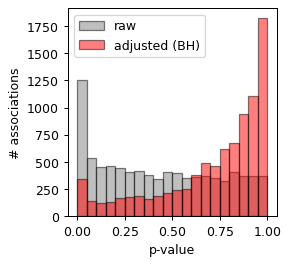

In [83]:
rcParams['figure.figsize'] = 3, 3
rcParams['figure.dpi'] = 90
plt.hist(res['p_val'], color='gray', bins=20, label='raw', alpha=.5, edgecolor = 'black')
plt.hist(res['p_adj'], color='red', bins=20, label='adjusted (BH)', alpha=.5, edgecolor = 'black')
plt.xlabel('p-value')
plt.legend()
plt.ylabel('# associations')

In [84]:
res[res['p_adj'] < 0.05]

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
666,69,False,70,Gpatch1,True,0.142874,1.421160e-03,TBX/1,0.040446,Gpatch1_70
821,69,False,70,Thnsl2,True,0.142094,1.510167e-03,TBX/1,0.042565,Thnsl2_70
1351,69,False,70,Tle1,True,-0.156581,4.651741e-04,TBX/1,0.019027,Tle1_70
1483,69,False,70,Tatdn3,True,0.147655,9.729563e-04,TBX/1,0.031573,Tatdn3_70
1734,69,False,70,Trim59,True,0.138977,1.919361e-03,TBX/1,0.049644,Trim59_70
...,...,...,...,...,...,...,...,...,...,...
8723,251,True,252,Myb,True,0.145300,1.174261e-03,MYB/5,0.036361,Myb_252
8757,256,True,257,Trp53i13,True,-0.162064,2.898479e-04,P53-like/1,0.012820,Trp53i13_257
8761,257,True,258,Grhl2,True,0.209765,2.447935e-06,GRHL,0.000336,Grhl2_258
8765,260,True,261,Glis3,True,0.169514,1.487053e-04,GLIS,0.007647,Glis3_261


In [85]:
pval_thr = 1e-5
sel_genes = set(list(res[res['p_adj'] < pval_thr]['gene_name']))

In [86]:
log_act = ad.obsm['log_activities'].copy()

In [87]:
cols_act = ['intercept', 'dinuc_bias'] + [name_by_filter_id[k] for k in log_act.columns[2:]]
log_act.columns = cols_act

In [88]:
import anndata
ad_act = anndata.AnnData(log_act)
ad_act.obsm['X_umap'] = ad.obsm['X_umap']
ad_act.obs = ad.obs

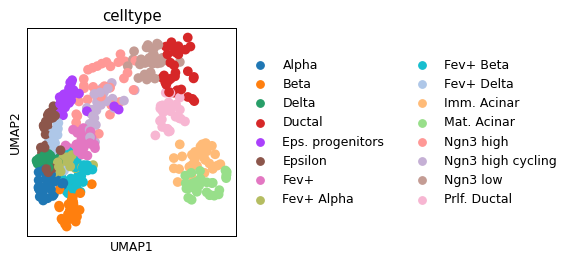

In [89]:
sc.pl.umap(ad_act, color='celltype')


Rank genes groups using the annotation

In [90]:
sc.tl.rank_genes_groups(ad_act, 'celltype')
rkg_df = []
for ct in ad_act.obs['celltype'].values.unique():
    print(ct)
    rkg_df2 = sc.get.rank_genes_groups_df(ad_act, ct)
    rkg_df2['celltype'] = ct
    rkg_df.append(rkg_df2)
rkg_df = pd.concat(rkg_df)
rkg_df['module_name'] = rkg_df['names'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
rkg_df['module_name'] = np.where(~pd.isnull(rkg_df['module_name']), rkg_df['module_name'], rkg_df['names'])
rkg_df.head()

Fev+ Delta
Prlf. Ductal
Fev+
Ductal
Beta
Eps. progenitors
Fev+ Beta
Fev+ Alpha
Epsilon
Ngn3 high
Ngn3 low
Ngn3 high cycling
Alpha
Imm. Acinar
Delta
Mat. Acinar


,names,scores,logfoldchanges,pvals,pvals_adj,celltype,module_name
0,SPZ1,2.315675,0.555740,0.022420,0.054719,Fev+ Delta,SPZ1
1,NFKB/1,2.073468,0.452050,0.042538,0.082751,Fev+ Delta,NFKB/1
2,YY1,1.463495,1.317628,0.149623,0.212273,Fev+ Delta,YY1
3,NR/14,1.447672,0.586391,0.150825,0.212930,Fev+ Delta,NR/14
4,ZNF41,1.415272,1.120923,0.158367,0.221406,Fev+ Delta,ZNF41


Get top modules

In [91]:
ad_act.var_names = ad_act.var_names.map(rkg_df.set_index('names')['module_name'].to_dict())

In [92]:
sc.tl.rank_genes_groups(ad_act, 'celltype')

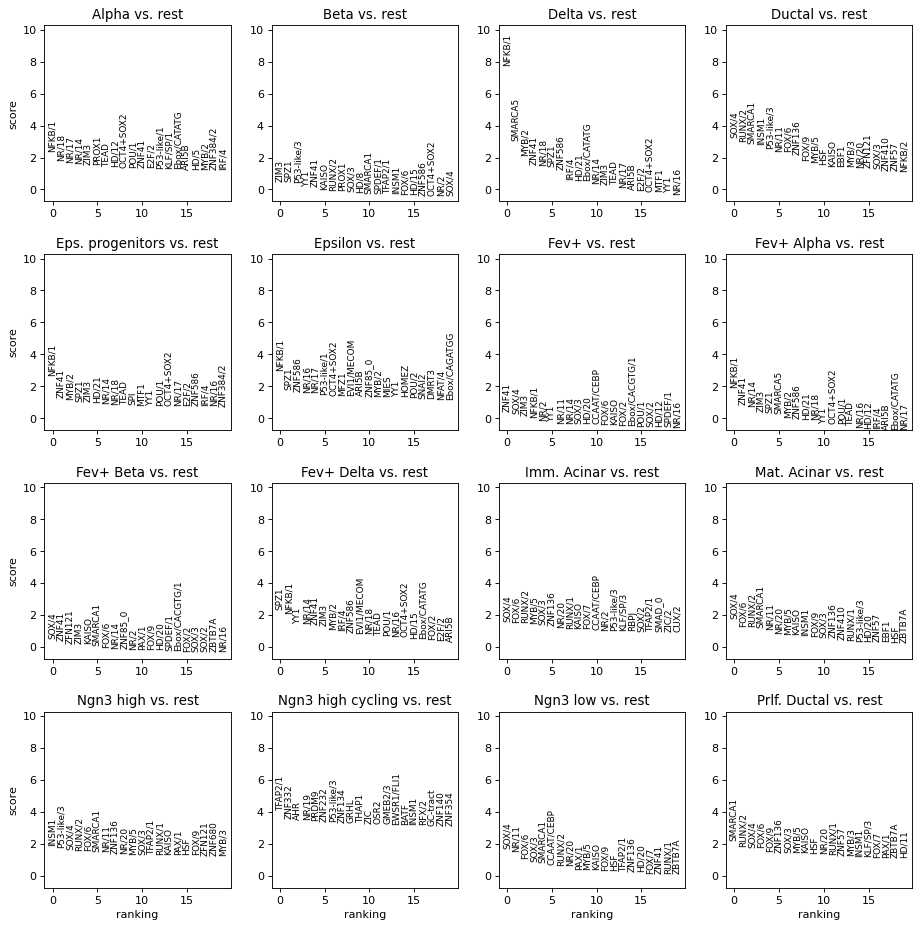

In [93]:
rcParams['figure.figsize'] = 3.5, 3.5
rcParams['figure.dpi'] = 80
sc.pl.rank_genes_groups(ad_act)


In [94]:
set(res[(res['p_adj'] < 1e-5)]['k'])

{'Arg1_248',
 'Arx_2',
 'Arx_248',
 'Arx_8',
 'Atp6v0b_70',
 'Auts2_70',
 'Ctsf_70',
 'Dbpht2_52',
 'Dbpht2_70',
 'Dst_70',
 'Gprasp2_109',
 'Gstz1_70',
 'Isl1_2',
 'Malat1_70',
 'Mboat4_70',
 'Mecom_241',
 'Meis2_69',
 'Ptma_70',
 'Ptprn2_70',
 'Runx1t1_179',
 'Runx1t1_70',
 'St18_70',
 'Stmn1_70',
 'Stxbp5l_70',
 'Tkt_70',
 'Tmem59_70',
 'Tubb5_70',
 'Zbtb20_70'}

In [95]:
res[res['module_name'].str.contains('HD')].sort_values('p_adj')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
4403,1,True,2,Isl1,True,-0.398203,2.692688e-20,HD/2,2.367950e-16,Isl1_2
4438,7,True,8,Arx,True,-0.254882,8.535323e-09,HD/8,3.950507e-06,Arx_8
4397,1,True,2,Arx,True,-0.254882,8.535323e-09,HD/2,3.950507e-06,Arx_2
4435,6,True,7,Fen1,True,0.177559,7.006147e-05,HD/7,4.464642e-03,Fen1_7
4421,1,True,2,Fen1,True,0.177559,7.006147e-05,HD/2,4.464642e-03,Fen1_2
...,...,...,...,...,...,...,...,...,...,...
3903,209,False,210,Hmbox1,True,-0.002689,9.523716e-01,HD/25,9.904056e-01,Hmbox1_210
15,1,False,2,Mien1,True,0.002888,9.488509e-01,HD/2,9.904056e-01,Mien1_2
46,9,False,10,Hnf1b,True,0.001996,9.646276e-01,HD/10,9.938803e-01,Hnf1b_10
4419,1,True,2,Gbx1,True,-0.001622,9.712650e-01,HD/2,9.949971e-01,Gbx1_2


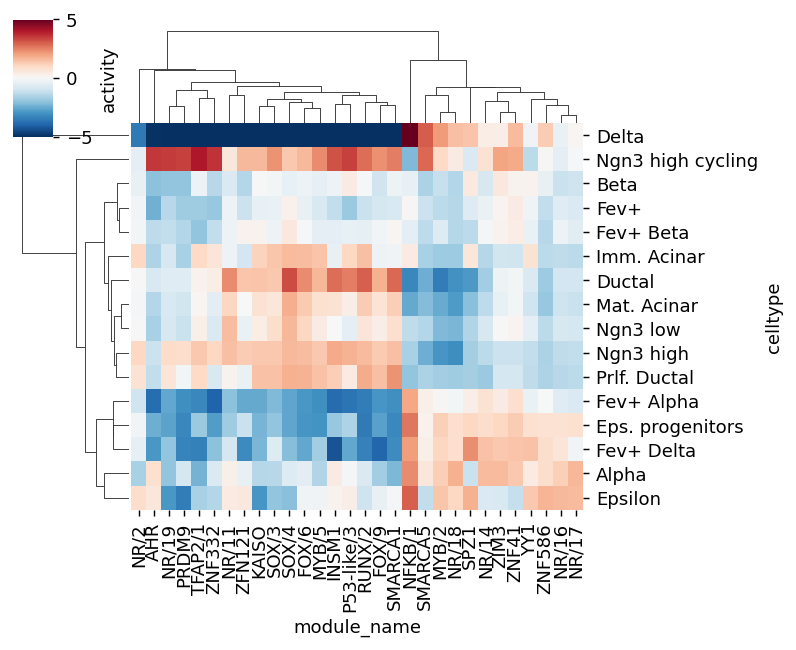

In [96]:
mod_names_best = set(rkg_df.sort_values('scores', ascending=False).groupby('celltype').head(5)['module_name'])
best = rkg_df[rkg_df['module_name'].isin(mod_names_best)]
rcParams['figure.dpi'] = 130
sns.clustermap(best.pivot(index='celltype', columns='module_name', values='scores'),
               cbar_kws={'label': 'activity'}, cmap='RdBu_r',
               vmin=-5, vmax=5,
               figsize=[6.2, 5],
               # dpi=100,
               xticklabels=True)


In [97]:
rna_tfs = rna_sel.to_df()[list(set(res['gene_name']))]
rna_tfs['celltype'] = rna_sel.obs['celltype']
mean_tfs = rna_tfs.groupby('celltype').mean()

act_tfs_df = ad_act.to_df()
act_tfs_df['celltype'] = ad_act.obs['celltype']
mean_act_tf = act_tfs_df.groupby('celltype').mean()

In [98]:
corr_celltype = []
for i, c1 in enumerate(mean_act_tf):
    if i % 50 == 0:
        print(i, mean_act_tf.shape[1])
    for j, c2 in enumerate(mean_tfs):
        if not c1 in genes_by_module_name or not c2 in genes_by_module_name[c1]:
            continue
        a = mean_act_tf[c1]
        b = mean_tfs[c2]
        corr_celltype.append([c1, c2] + list(spearmanr(a, b)))

0 288
50 288
100 288
150 288
200 288
250 288


In [99]:
# sc.pl.dotplot(rna_sel, groupby='celltype', var_names=list(set(res['gene_name'])))

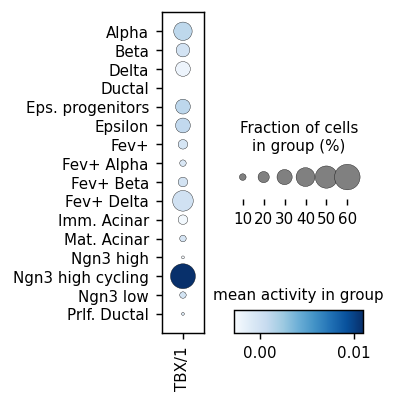

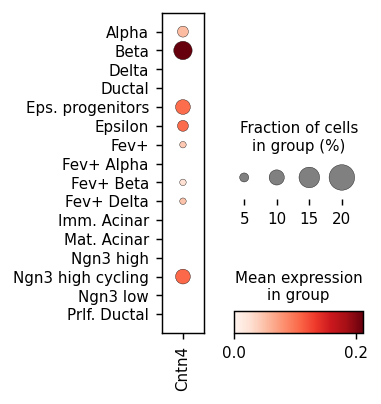

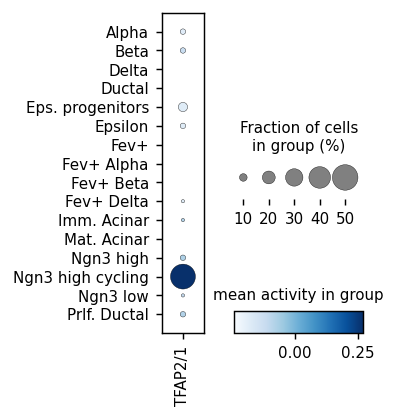

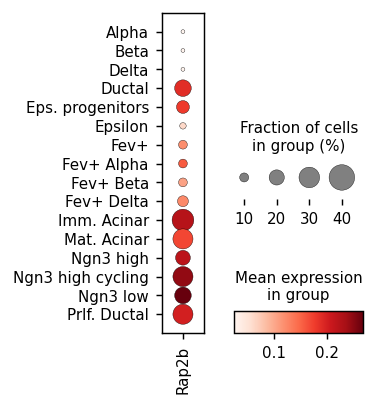

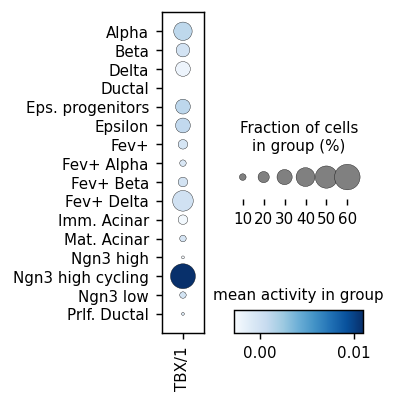

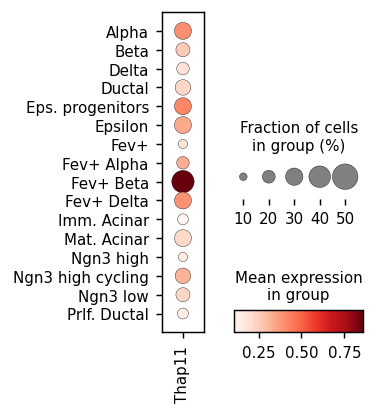

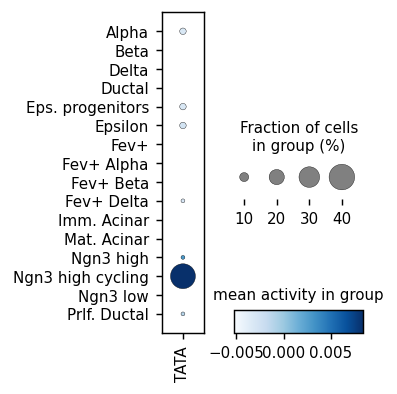

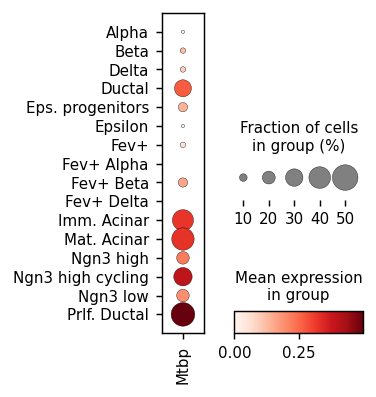

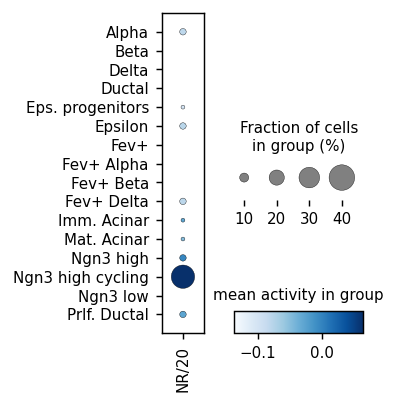

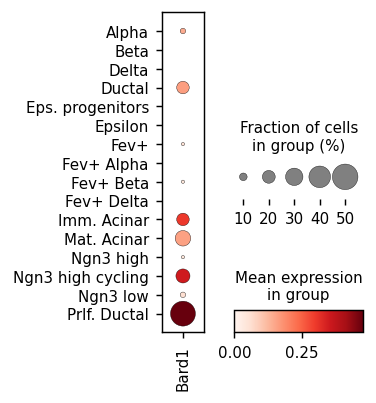

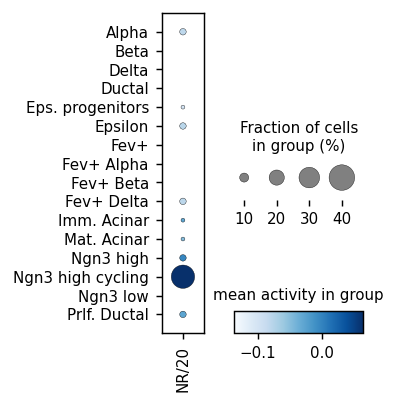

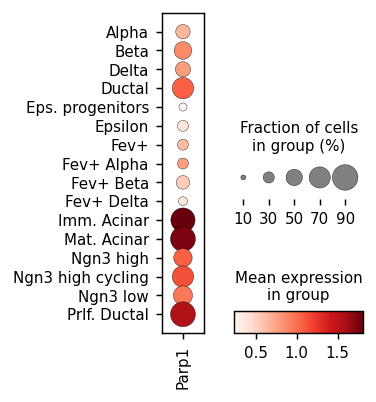

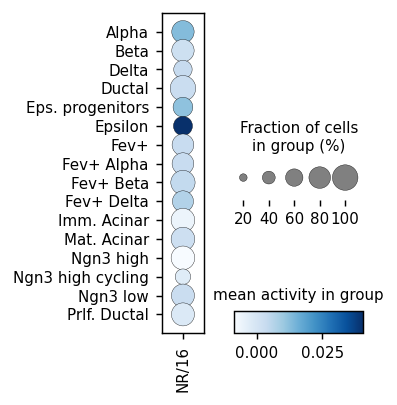

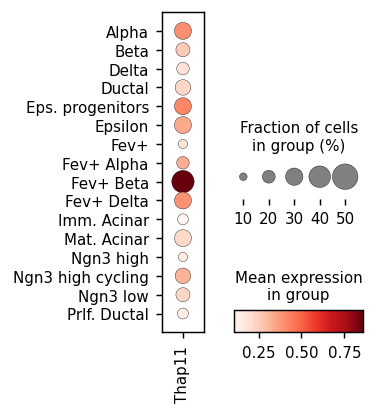

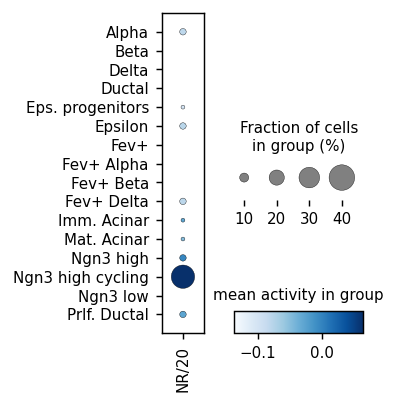

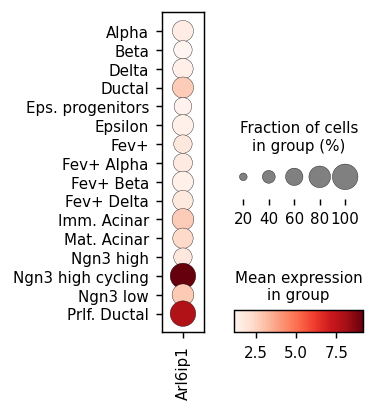

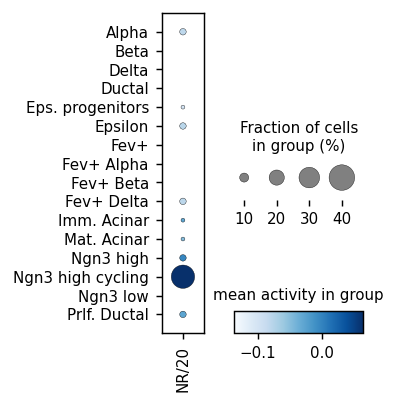

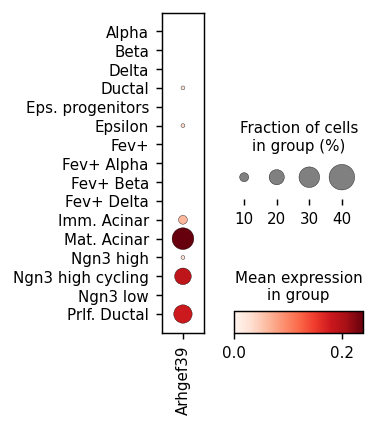

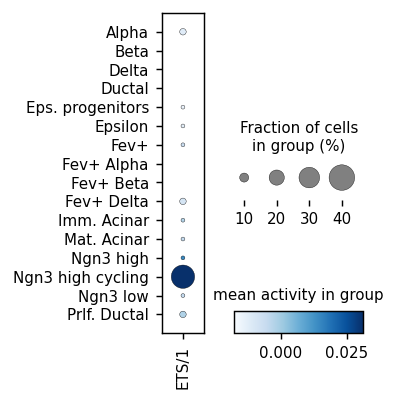

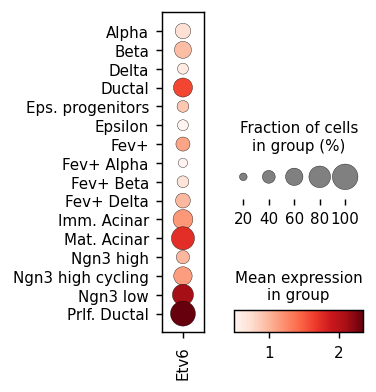

In [100]:
corr = pd.DataFrame(corr_celltype,
                    columns=['module_name', 'gene_name', 'rho', 'p_val'])
corr = corr.sort_values('rho', ascending=False)

for ri, r in corr.head(10).iterrows():
    # ad_act.obs['HD/2'] = log_act['HD/2']
    sc.pl.dotplot(ad_act,
                groupby='celltype',
                cmap='Blues',
                var_names=r['module_name'],
                figsize=[2, 3.2],
                colorbar_title='mean activity in group')
    sc.pl.dotplot(rna_sel,
                  groupby='celltype',
                  var_names=r['gene_name'],
                  figsize=[2, 3.2])

In [101]:
### attempt to show together

for key_interaction in varm_ligrec_by_k:
    # if not 'Resident' in key_interaction:
    #     continue
    
    viz = varm_ligrec_by_k[key_interaction]
        
    obs = viz[['group']]
    obs['k2'] = obs.index.str.replace('index_', '').str.replace('neighbor', '') + '_' + obs['group']
    viz = anndata.AnnData(viz[viz.columns[1:]], obs=obs)


    import matplotlib.pyplot as plt
    from matplotlib import rcParams
    from matplotlib import colors
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    plt.rcParams['figure.dpi'] = 150
    SMALL_SIZE = 14
    MEDIUM_SIZE = 19
    BIGGER_SIZE = 21
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    viz_df = viz.to_df()
    print(viz_df.shape)

    viz_df.index = viz.obs['k2']
    z = viz_df.copy()
    for c in z:
        z[c] = (z[c] - z[c].mean()) / z[c].std()

    tree_genes_2 = viz_df.idxmax(axis=1).to_dict()

    tree_genes = {}
    for k in tree_genes_2:
        tree_genes[k] = set([tree_genes_2[k]])

    z = z.T
    tree_genes = {}
    n = 3
    for c in z:
        tree_genes[c] = set(z.sort_values(c, ascending=False).index[:n])
    tree_genes

    diagonal_rectangle_heights = { k: 1 for k in tree_genes}
    #     'AT1'                                  :2,
    #     'AT2'                                  :2,
    #     'Club'                                 :2,
    #     'Multiciliated'                        :2,
    #     'Deuterosomal'                         :2,
    # #    'Basal'                                :2,
    # #    'Smooth muscle'                        :2,
    # #    'Pericytes'                            :2,
    # #    'Adventitial Fibroblast'               :1,
    # #    'Alveolar Fibroblast'                  :2,
    # #    '(Vascular) Endothelial cell'          :2,
    # #    'Cappillary (G) endothelial cell'      :2,
    # #    'Cappillary Aerocyte endothelial cell' :1,
    # #    'Lymphatic EC'                         :1,    
    #     'Lymphocyte'                           :2,
    # #    'DC'                                   :1,
    # #   'Monocytes'                            :1,
    # #    'Alv Macrophage'                       :2,
    #     'Interstitial macrophages'             :2,
    #     'Mast cells'                           :2,
    # }

    dot_color_df = viz_df # [list(set(g for k in tree_genes for g in tree_genes[k]))]
    # dot_color_df[dot_color_df < 0] = -dot_color_df[dot_color_df < 0]
    # dot_color_df.index = viz.obs_names

    sc_ct_list = [k for k in set(viz.obs['k2']) if 'immune' in k]
    ST_ct_list_with_space = [k for k in set(viz.obs['k2']) if 'tumor' in k]

    genes_by_group = {}
    for ri, r in cellphone_interactions.iterrows():
        # print(r)
        a, b = str(r['protein_name_a']).split('_')[0], str(r['protein_name_b']).split('_')[0]

        found_a = False
        found_b = False
        for ct in tree_genes:
            if a in tree_genes[ct]:
                found_a = True
            if b in tree_genes[ct]:
                found_b = True

        key_class = ' '.join(str(r['classification']).split(' ')[2:])
        if key_class == '':
            key_class = 'Others'
        # print(key_class)

        if a != 'nan' and found_a:
            if not key_class in genes_by_group:
                genes_by_group[key_class] = set()
            genes_by_group[key_class].add(a)
        if b != 'nan' and found_b:
            if not key_class in genes_by_group:
                genes_by_group[key_class] = set()
            genes_by_group[key_class].add(b)
        # if a in cpdb_names or b in cpdb_names:


    ## remove duplicates and empty
    order = [v for g in genes_by_group for v in genes_by_group[g]]
    order = list(dict.fromkeys(order))
    # order
    found_genes = set()
    for g in genes_by_group:
        values_group = [v for v in genes_by_group[g]]
        for v in values_group:
            if not v in found_genes:
                found_genes.add(v)
            else:
                genes_by_group[g].remove(v)

    # remove empty gruops
    key_groups = list(genes_by_group.keys())
    for g in key_groups:
        if len(genes_by_group[g]) == 0:
            del genes_by_group[g]

    fig = plt.figure(figsize=(10,5),
                    dpi=150)
    ax = plt.gca()

    reduced_tree_genes = {ct: tree_genes[ct] for ct in diagonal_rectangle_heights}

    print(viz.shape, dot_color_df.shape)
    # one can add arbitrary names
    # reduced_tree_genes['hello'] = reduced_tree_genes['AngiogenicTAMs:_MES2like2_immune']

    vmax = 0.2
    dp = sc.pl.DotPlot(viz,
                    genes_by_group, # reduced_tree_genes,
                    groupby="k2",
                    ax=ax,cmap="bwr",
                    vmin=-vmax,vmax=vmax,
                    var_group_rotation=90, # var_group_positions='ha',
                    dot_color_df=dot_color_df)
                    # standard_scale='var')

    # dp.dot_max = .9
    # dp.dot_min = 0.01
    # dp.smallest_dot=.15
    dp.make_figure()

    # assuming no duplicates, this is the matrix to inspect pairs.
    data = dot_color_df[[v for g in genes_by_group for v in genes_by_group[g]]]

    x_coord = 0

    thr_max = .1
    thr_diff = .1
    diffs = []
    for ci, c in enumerate(data):
        for i in range(0, len(data[c]), 2):
            a, b = data[c][i], data[c][i + 1]
            diffs.append([c, a, b, abs(a - b)])
            if abs(a - b) > thr_diff and abs(max(a, b)) > thr_max and (a > 0 or b > 0):
                print(c, a, b)
                rect = patches.Rectangle((ci, i), 1, 2,
                                        linewidth=2,
                                        linestyle='--',
                                        edgecolor='green',
                                        facecolor='none')#, zorder=1)
                dp.ax_dict["mainplot_ax"].add_patch(rect)

    for ct,height in diagonal_rectangle_heights.items():
        break
        print(ct, height)
        y = dot_color_df.index.get_loc(ct)
        width = len(tree_genes[ct])
        if height != 0:
            rect = patches.Rectangle((x_coord, y), width, height, linewidth=1, edgecolor='black', facecolor='none')#, zorder=1)
            dp.ax_dict["mainplot_ax"].add_patch(rect)
        x_coord += width
        

    old_ytick_labels = dp.ax_dict["mainplot_ax"].get_yticklabels()
    new_ticks = []
    yshift = 0
    for i, lab in enumerate(old_ytick_labels):
        # print(lab)
        x, y = lab.get_position()
        old_text = lab._text
        if lab._text in sc_ct_list:
            lab._text = '_'.join(lab._text.split('_')[:2]) + ' ' + lab._text.split('_')[-1]
            lab.set_color('purple')
            lab.set_x(x)
            lab.set_y(y + yshift)
            # print(x, y)
            new_ticks.append(y + yshift)
        elif lab._text in ST_ct_list_with_space:
            lab._text = old_text.split('_')[-1]
            lab.set_color('green')
            new_ticks.append(y + yshift)
        old_ytick_labels[i] = lab

    # print(old_ytick_labels)
    dp.ax_dict["mainplot_ax"].set_yticklabels(old_ytick_labels)
    print(dp.ax_dict["mainplot_ax"].get_yticklabels())
    print(dp.ax_dict["mainplot_ax"].set_yticks(new_ticks))
    print(dp.ax_dict["mainplot_ax"].get_yticks())


    # plt.show()
    # fig.savefig("./dotplot_sc_and_ST.png", bbox_inches = "tight")

    # break


NameError: name 'varm_ligrec_by_k' is not defined

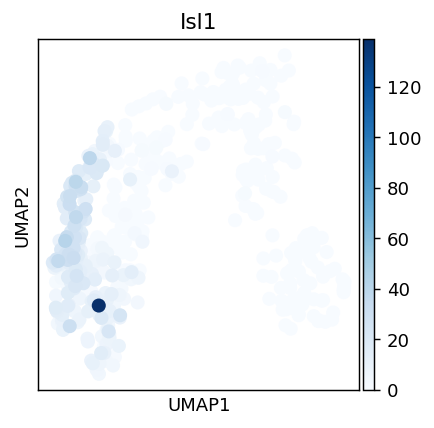

In [ ]:
sc.pl.umap(rna_sel, color='Isl1', cmap='Blues')


In [ ]:
ad_act

AnnData object with n_obs × n_vars = 496 × 288
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic_score_z2', 'dynamic_score_abs', 'umap_density_dynamic_score_z1', 'umap_density_dynamic_score_z2'
    uns: 'celltype_colors', 'rank_genes_groups'
    obsm: 'X_umap'

In [ ]:
from matplotlib import rcParams, cm
cmap = cm.get_cmap('YlOrRd')
cmap.set_over('black')
cmap.set_under('lightgray')

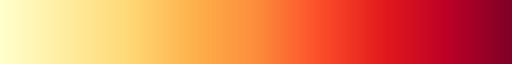

In [ ]:
cmap

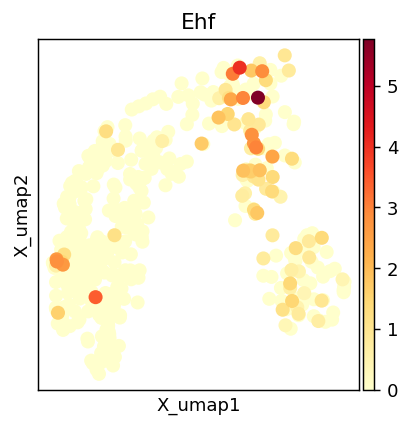

In [ ]:
sc.pl.embedding(rna_sel, basis='X_umap', color='Ehf', color_map=cmap)
